In [1]:
from argparse import Namespace
from dataset import TextDataset
from classifier import BOWClassifier
import torch

/home/nikos/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def use_cuda():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Namespace (
    in_features=None,
    units_per_layer=[128, 64],
    dataset=None,
    optimizer="Adam",
    criterion="bce_logits",
    save_dir='../trained_models/bow.pth',
    batch_size=128,
    learning_rate=0.001,
    num_epochs=5,
    device=use_cuda(),
    binary_class=True
)

In [3]:
args.dataset = TextDataset.load_dataset_and_make_vectorizer("../data/IMDB-dataset.csv")
args.in_features = len(args.dataset.get_vectorizer().text_vocab)
args.out_features = len(args.dataset.get_vectorizer().label_vocab)

[nltk_data] Downloading package stopwords to /home/nikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nikos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nikos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
bow = BOWClassifier(args=args)
bow.setup()
bow.fit()

100%|██████████| 5/5 [02:27<00:00, 29.47s/it]


In [5]:
loss, acc, f1 = bow.eval_net(mode='test')
print(loss)
print(acc)
print(f1)

0.3033913773221846
88.4214743589744
88.39915586630694


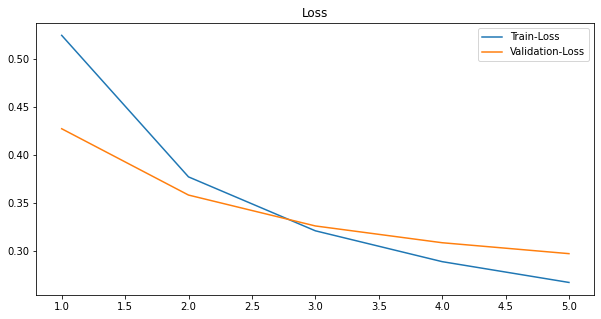

In [6]:
bow.plot_logs(title="Loss", legend=["Train-Loss", "Validation-Loss"])

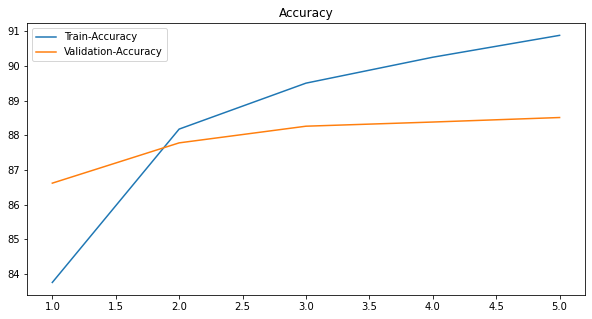

In [7]:
bow.plot_logs(title="Accuracy", legend=["Train-Accuracy", "Validation-Accuracy"])

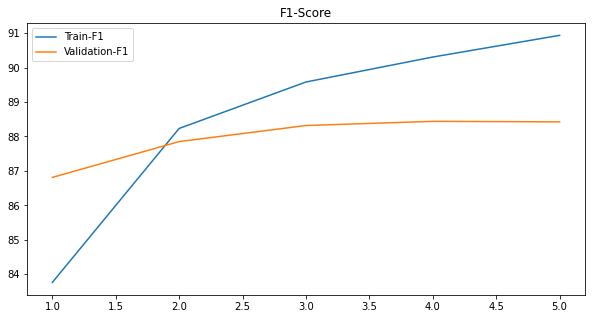

In [8]:
bow.plot_logs(title="F1-Score", legend=["Train-F1", "Validation-F1"])